In [98]:
import cv2
import imutils
from skimage.filters import threshold_local
# from pyimagesearch.transform import four_point_transform
import numpy as np
import random as rng
from matplotlib import pyplot as plt

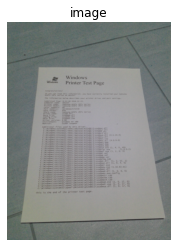

In [99]:
rng.seed(12345)

# read and show the input image
img_path = 'document.jpeg'
img = cv2.imread(img_path)
plt.imshow(img)
plt.title("image")
plt.axis('off')
plt.show()

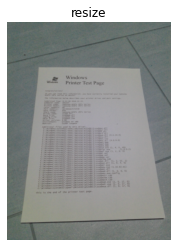

In [100]:
ratio = img.shape[0] / 500.0 # find the ratio
input_img = imutils.resize(img, height = 500) # resize the image to 500 
plt.imshow(input_img)
plt.title("resize")
plt.axis("off")
plt.show()

In [101]:
def sort_contours(elem):
    return cv2.arcLength(elem, closed=True)

def display_contours(val):
    threshold = val
    # Detect edges using Canny
    canny_output = cv2.Canny(src_gray, threshold, threshold * 3)
    # Find contours
    contours, _ = cv2.findContours(canny_output, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

    # get the largest contour by sorting the contours wrt arcLength
    contours = sorted(contours, key=sort_contours, reverse=True)[:1]

    # Find the convex hull object for each contour
    # hull_list = []
    # for cnt in contours:
    #     hull = cv2.convexHull(cnt)
    #     hull_list.append(hull)
    
    #     # Draw contours + hull results
    convex_hull_mask = np.zeros((canny_output.shape[0], canny_output.shape[1], 3), dtype=np.uint8)

    hull_output = cv2.convexHull(contours[-1])

    color = (rng.randint(0,256), rng.randint(0,256), rng.randint(0,256))
    # # cv2.drawContours(drawing, contours, -1, color, 1)
    cv2.drawContours(convex_hull_mask, hull_output, -1, color, 1)


    src_houghlinesp = convex_hull_mask.copy()

    convex_hull_mask_grayscale = cv2.cvtColor(convex_hull_mask, cv2.COLOR_BGR2GRAY)


    # # rho: The resolution parameter rho in pixels.
    # # theta: The resolution of the parameter \theta in radians.
    # # threshold: The minimum number of intersecting points to detect a line.


    lines = cv2.HoughLinesP(image = convex_hull_mask_grayscale, rho = 1, theta = np.pi / 180, minLineLength=100, maxLineGap=20, threshold=10)

    print("lines", lines)

    if lines is not None:
        for i in range(0, len(lines)):
            l = lines[i][0]
            cv2.line(src_houghlinesp, (l[0], l[1]), (l[2], l[3]), (0,0,255), 3, cv2.LINE_AA)

    


    cv2.imshow('Source', canny_output)
    # cv2.waitKey(10)
    cv2.imshow('Hough lines', src_houghlinesp)
    cv2.waitKey(10)
    

In [102]:
def get_quadrilateral(grayscale, output):
  convex_hull_mask = np.zeros((grayscale.shape[0], grayscale.shape[1], 3), dtype=np.uint8)


  convex_hull_mask_grayscale = cv2.cvtColor(convex_hull_mask, cv2.COLOR_BGR2GRAY)

  # Find contours
  contours, _ = cv2.findContours(grayscale, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

  # get the largest contour by sorting the contours wrt arcLength
  contours = sorted(contours, key=sort_contours, reverse=True)[:1]

  # convex hull object
  hull_list = []
  hull = cv2.convexHull(contours[-1], False)
  hull_list.append(hull)

  # cv2.drawContours(convex_hull_mask, contours, -1, (0,255,0), 2, 8, hierarchy)
  cv2.drawContours(convex_hull_mask_grayscale, hull_list, -1, (255,0,0), 2, 8)

  cv2.imshow('Convex Hull Mask', convex_hull_mask_grayscale)
  cv2.waitKey(10)


  lines = cv2.HoughLinesP(image = convex_hull_mask_grayscale, rho = 1, theta = np.pi / 200, minLineLength=50, maxLineGap=50, threshold=10)


  print("lines size ", len(lines))
  print("lines", lines)

  src_houghlinesp = output.copy()


  if lines is not None:
      for i in range(0, len(lines)):
        l = lines[i][0]
        cv2.line(src_houghlinesp, (l[0], l[1]), (l[2], l[3]), (0,0,255), 3, cv2.LINE_AA)

  

  cv2.imshow('Lines', src_houghlinesp)
  cv2.waitKey(10)

  



In [124]:
# Convert image to gray and blur it
input_grey = cv2.cvtColor(input_img, cv2.COLOR_BGR2GRAY)
input_grey = cv2.GaussianBlur(input_grey, (3,3), 0)
ret, input_grey = cv2.threshold(input_grey, 130, 180, cv2.THRESH_BINARY)

source_window = 'Source'
cv2.namedWindow(source_window)

max_thresh = 255
thresh = 70 # initial threshold
# cv2.createTrackbar('Canny Thresh:', source_window, thresh, max_thresh, display_contours)

# display_contours(80)
edges = cv2.Canny(input_grey, 83, 300)

cv2.imshow('Source', edges)

corners = get_quadrilateral(edges, input_img)

# edged_img = cv2.Canny(src_blur, 80,200) # edge detection using Canny edge detection
# plt.imshow(edged_img)
# plt.title("edged")
# plt.axis('off')
# plt.show()

lines size  17
lines [[[ 71 104 298 104]]

 [[302 105 362 449]]

 [[ 31 459  70 106]]

 [[ 74 102 237 102]]

 [[304 106 358 418]]

 [[ 72 103 278 103]]

 [[ 47 459 361 450]]

 [[ 30 458 361 448]]

 [[ 46 337  72 105]]

 [[ 30 457  63 163]]

 [[ 32 459  71 105]]

 [[351 393 361 449]]

 [[239 105 301 105]]

 [[ 79 459 345 451]]

 [[ 33 459 360 449]]

 [[351 378 362 445]]

 [[307 120 318 181]]]


In [ ]:
cnts,_ = cv2.findContours(edged_img.copy(),cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE) # find all the contours
print(cnts);

# cv2.drawContours(img, cnts, -1, (0, 255, 0), 3)
  
# cv2.imshow('Contours', img)
# cv2.waitKey(5000)

# Sorting the contours in descending order based on their contour area and just taking the first 5
cnts = sorted(cnts,key=cv2.contourArea,reverse=True)

c = cnts[0]
peri = cv2.arcLength(c,True)
approx = cv2.approxPolyDP(c,0.03*peri,True)
x, y, w, h = cv2.boundingRect(c)
print(x,y,w,h)
to_show = img.copy()
# draw a green rectangle to visualize the bounding rect
cv2.rectangle(to_show, (x, y), (x+w, y+h), (0, 255, 0), 2)
plt.imshow(to_show)
plt.title("contour")
plt.show()

# Traversing in contours and finding the contour with 4 sides using cv2.approxPolyDP().
# for c in cnts:
#     peri = cv2.arcLength(c,True)
#     approx = cv2.approxPolyDP(c,0.096*peri,True)
#     x, y, w, h = cv2.boundingRect(c)
#     # draw a green rectangle to visualize the bounding rect
#     cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 2)
#     plt.imshow(img)
#     plt.title("soemthing")
#     plt.show()
#     print(len(approx), cv2.contourArea(c))
#     if len(approx)==4:
#         doc = approx
#         break

In [ ]:
len(cnts)

In [ ]:
# draw points/circles around the corners of the document. 
p=[]
for d in doc:
    tuple_point = tuple(d[0])
    cv2.circle(img,tuple_point,3,(0,0,255),4)
    p.append(tuple_point)
    
cv2.imshow('Corner points detected',img)
cv2.waitKey(0)

In [ ]:
def order_points(pts):
    # initialzie a list of coordinates that will be ordered
    # such that the first entry in the list is the top-left,
    # the second entry is the top-right, the third is the
    # bottom-right, and the fourth is the bottom-left
    rect = np.zeros((4, 2), dtype = "float32")

    # the top-left point will have the smallest sum, whereas
    # the bottom-right point will have the largest sum
    s = pts.sum(axis = 1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]

    # now, compute the difference between the points, the
    # top-right point will have the smallest difference,
    # whereas the bottom-left will have the largest difference
    diff = np.diff(pts, axis = 1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]

    # return the ordered coordinates
    return rect

def four_point_transform(image, pts):
    # obtain a consistent order of the points and unpack them
    # individually
    rect = order_points(pts)
    (tl, tr, br, bl) = rect

    # compute the width of the new image, which will be the
    # maximum distance between bottom-right and bottom-left
    # x-coordiates or the top-right and top-left x-coordinates
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))

    # compute the height of the new image, which will be the
    # maximum distance between the top-right and bottom-right
    # y-coordinates or the top-left and bottom-left y-coordinates
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))

    # now that we have the dimensions of the new image, construct
    # the set of destination points to obtain a "birds eye view",
    # (i.e. top-down view) of the image, again specifying points
    # in the top-left, top-right, bottom-right, and bottom-left
    # order
    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype = "float32")

    # compute the perspective transform matrix and then apply it
    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))

    # return the warped image
    return warped

In [ ]:
# apply four point transform to extract the document rectangle
warped = four_point_transform(org, doc.reshape(4, 2) * ratio)
warped = cv2.cvtColor(warped, cv2.COLOR_BGR2GRAY)
cv2.imshow("Warped", imutils.resize(warped, height = 650))
cv2.waitKey(0)

In [ ]:
# give a black and white feel to the image
T = threshold_local(warped, 11, offset = 10, method = "gaussian")
warped = (warped > T).astype("uint8") * 255
cv2.imshow("Scanned", imutils.resize(warped, height = 650))
cv2.waitKey(0)
cv2.destroyAllWindows()